In [1]:
import os

import cv2

import numpy as np
import pandas as pd
import logging
import os


import pandas as pd
from sklearn.preprocessing import LabelEncoder

logger = logging.getLogger(__name__)
encoder = LabelEncoder()

import torch
import torch.optim as optim
import torchvision.transforms as T
from torchvision.utils import make_grid 
from torch.utils.data import DataLoader, Dataset

from retinanet import model
from retinanet.dataloader import collater, Resizer, Augmenter, Normalizer, UnNormalizer

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from dataset import FracAtlasDataset
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
def plot_img(df,img_path):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 10))
    ax = ax.flatten()
    
    records = df[df['filename'] == img_path]
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    

    
    for idx, row in records.iterrows():
        box = row[['xmin', 'ymin', 'xmax', 'ymax']].values
        xmin = int(box[0])
        ymin = int(box[1])
        xmax = int(box[2])
        ymax = int(box[3])
        
        cv2.rectangle(image2, (int(xmin),int(ymin)), (int(xmax),int(ymax)), (255,0,0), 3)
    
    ax[1].set_title('Image with Bondary Box')

    ax[1].imshow(image2)
    

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


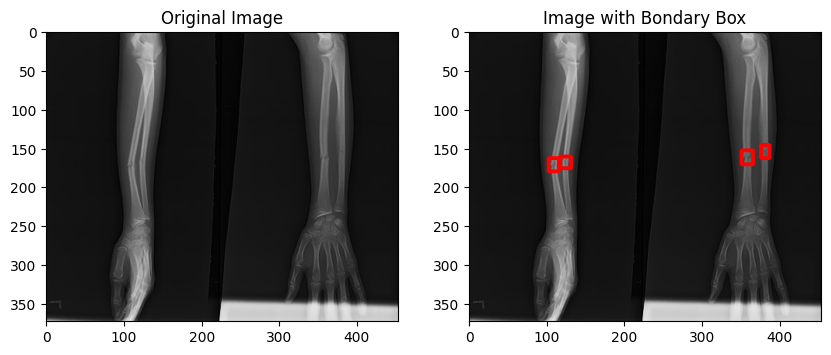

In [4]:
df = pd.read_csv('data.csv')
plot_img(df,'/home/saeid/MP/Project/FracAtlas/all_images/IMG0002395.jpg')

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [6]:
import matplotlib.patches as mpatches

def draw_prediction(model, input_tensor,):

    data = input_tensor
    data['img'] = data['img'].permute(2, 0, 1).unsqueeze(0)
    model.eval()
    scores, classification, transformed_anchors = model(data['img'].float())
    # idxs= np.argmax(scores.cpu().detach().numpy())
    idxs = np.where(scores.cpu()>0.5)

    unnormalize = UnNormalizer()

    img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()
    
    
    img[img<0] = 0
    img[img>255] = 255

    img = np.transpose(img, (1, 2, 0))

    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for j in range(data['annot'].shape[0]):
        cv2.rectangle(img, (int(data['annot'][j][0]), int(data['annot'][j][1])), (int(data['annot'][j][2]), int(data['annot'][j][3])), 
                      color = (0, 255, 0), thickness = 2)
    
    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :] 
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])

        
        cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 2)

    
    predicted_patch = mpatches.Patch(color='blue', label='Predicted Box')
    ground_truth_patch = mpatches.Patch(color='green', label='Ground Truth Box')
    ax.legend(handles=[predicted_patch, ground_truth_patch], loc='lower right')


    ax.imshow(img)
    plt.show()
    

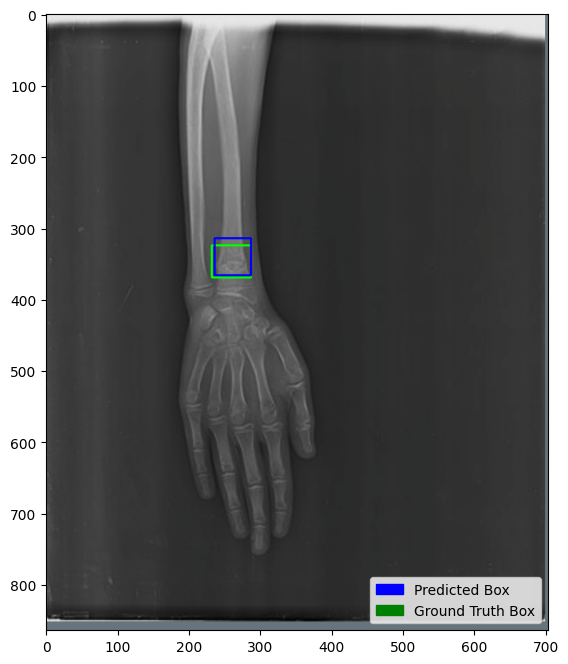

In [7]:

retinanet = torch.load('/home/saeid/MP/Project/retinanet_scratch_0.290.pt', map_location="cpu")


test_data= pd.read_csv("test_filtered.csv",)
test_dataset = FracAtlasDataset(test_data, mode = "valid", transforms = T.Compose([Normalizer(), Resizer()]))


draw_prediction(retinanet,test_dataset[10])

In [10]:
from evaluation_metric import calc_iou, calculate_recall_precision, calculate_iou, compute_metrics

test_data_loader = DataLoader(
        test_dataset,
        batch_size = 1,
        shuffle = False,
        num_workers = 16,
        collate_fn = collater,
        pin_memory=True)

pr, iou, map_50 = compute_metrics(retinanet, test_data_loader)
print('Training with random initialization:')
print(f'Percision: {pr[0]:.3f}')
print(f'Recall: {pr[1]:.3f}')
print(f'IoU: {iou:.3f}')
print(f'mAP@0.5: {map_50:.3f}')


Training with random initialization:
Percision: 0.393
Recall: 0.135
IoU: 0.201
mAP@0.5: 0.182


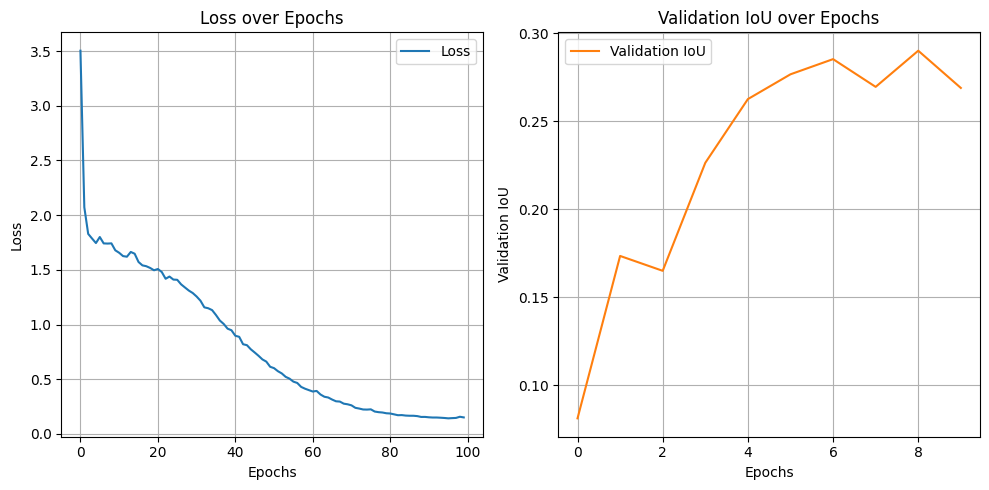

In [ ]:
import json

with open('train_loss_scratch.txt', 'r') as file:
        loss_list = json.load(file)

with open('val_iou_scratch.txt', 'r') as file:
        val_iou_list = json.load(file)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(loss_list, color='tab:blue', label='Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Epochs')
axs[0].legend()
axs[0].grid()

axs[1].plot(val_iou_list, color='tab:orange', label='Validation IoU')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Validation IoU')
axs[1].set_title('Validation IoU over Epochs')
axs[1].legend()
axs[1].grid()


plt.tight_layout()
plt.show()

Pretrained Model

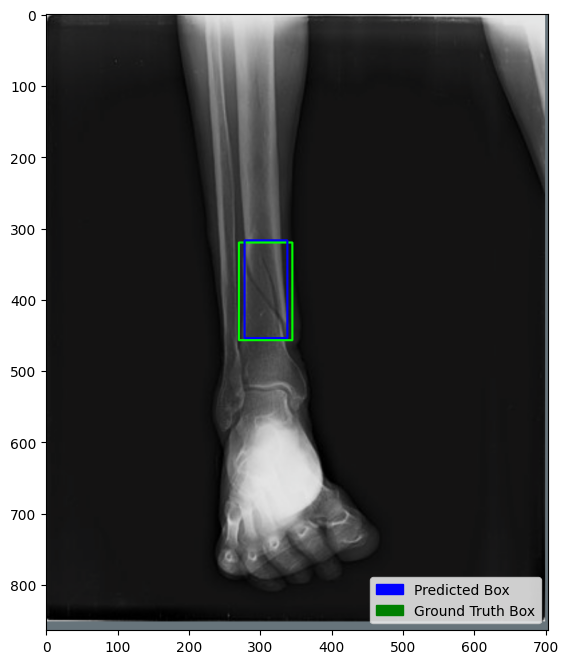

In [11]:
retinanet_pretrained = torch.load('/home/saeid/MP/Project/retinanet_pretrained_0.446.pt', map_location="cpu")

draw_prediction(retinanet_pretrained,test_dataset[41])

In [12]:
pr, iou, map_50 = compute_metrics(retinanet_pretrained, test_data_loader)
print('Training with pretrained model:')
print(f'Percision: {pr[0]:.3f}')
print(f'Recall: {pr[1]:.3f}')
print(f'IoU: {iou:.3f}')
print(f'mAP@0.5: {map_50:.3f}')


Training with pretrained model:
Percision: 0.869
Recall: 0.419
IoU: 0.531
mAP@0.5: 0.674
